
<a href="https://colab.research.google.com/github/takzen/financial-ai-engineering-showcase/blob/main/notebooks/week_05_time_series/06_project_volatility_forecaster.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🌪️ Tydzień 5, Dzień 6: Projekt - Volatility & Price Forecaster

To finałowy projekt modułu Time Series. Zbudujemy system hybrydowy.

**Architektura:**
1.  **Cena (Mean):** Model **NHITS** (NeuralForecast) przewidzi trend centralny.
2.  **Ryzyko (Variance):** Model **GARCH** przewidzi "szerokość" tunelu wahań.
3.  **Wynik:** Wykres wachlarzowy (Fan Chart) dla Bitcoina.

---
### 🛠️ 1. Instalacja

Łączymy biblioteki z całego tygodnia.

In [ ]:
!uv add neuralforecast arch yfinance pandas numpy matplotlib seaborn

### 📥 2. Pobieranie Danych

Pobieramy Bitcoina (BTC-USD). To aktywo idealne do tego projektu, bo ma silne trendy i dziką zmienność.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Konfiguracja
TICKER = "BTC-USD"
HORIZON = 7 

print(f"📥 Pobieranie {TICKER}...")
df = yf.download(TICKER, start="2022-01-01", progress=False, auto_adjust=True)

# --- POPRAWKA PRZYGOTOWANIA DANYCH ---

# 1. Spłaszczamy MultiIndex, jeśli istnieje, biorąc poziom 'Close'
if isinstance(df.columns, pd.MultiIndex):
    # xs pozwala bezpiecznie wyciąć przekrój 'Close'
    df = df.xs('Close', axis=1, level=0, drop_level=True)
elif 'Close' in df.columns:
    df = df[['Close']]

# 2. Resetujemy indeks (Data staje się kolumną)
nf_df = df.reset_index()

# 3. Wybieramy dwie pierwsze kolumny "na ślepo" (zawsze będzie to [Data, Cena])
# To chroni nas przed zmianą nazwy kolumny ceny na ticker
nf_df = nf_df.iloc[:, :2]

# 4. Nadajemy wymagane nazwy
nf_df.columns = ['ds', 'y']
nf_df['unique_id'] = TICKER

print("✅ Dane gotowe. Podgląd:")
display(nf_df.tail())

📥 Pobieranie BTC-USD...
✅ Dane gotowe. Podgląd:


,ds,y,unique_id
1440,2025-12-11,92511.335938,BTC-USD
1441,2025-12-12,90270.414062,BTC-USD
1442,2025-12-13,90298.710938,BTC-USD
1443,2025-12-14,88175.179688,BTC-USD
1444,2025-12-15,85894.765625,BTC-USD


### 🧠 3. Prognoza CENY (NHITS)

Używamy sieci neuronowej do przewidzenia, gdzie cena będzie za 7 dni (średnio).

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
import torch

# --- FIX: OPTYMALIZACJA GPU ---
# To ustawienie mówi PyTorchowi: "Używaj Tensor Cores, nawet jeśli stracimy 0.0001 precyzji".
# Usuwa warning i przyspiesza trening.
torch.set_float32_matmul_precision('medium')
# ------------------------------

# Definicja modelu
nhits = NHITS(
    input_size=30,       # Patrz 30 dni wstecz
    h=HORIZON,           # Przewiduj 7 dni w przód
    max_steps=200,       # Szybki trening
    scaler_type='standard'
)

nf = NeuralForecast(models=[nhits], freq='D')

print("⏳ Trenowanie modelu NHITS...")
nf.fit(df=nf_df)

# Prognoza
future_price = nf.predict()
print("✅ Prognoza ceny gotowa.")
display(future_price)

### ⚡ 4. Prognoza RYZYKA (GARCH)

Teraz używamy GARCH, żeby przewidzieć zmienność na te same 7 dni.
Pamiętaj: GARCH działa na **Zwrotach** (Returns), a nie na cenach.

In [4]:
from arch import arch_model

# 1. Obliczamy zwroty (w procentach, dla stabilności GARCH)
returns = 100 * df.pct_change().dropna()

# 2. Trenujemy GARCH(1,1)
garch = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = garch.fit(disp='off')

# 3. Prognoza wariancji na 7 dni
forecast_var = garch_fit.forecast(horizon=HORIZON)
variance = forecast_var.variance.iloc[-1].values

# 4. Zamiana na Odchylenie Standardowe (Volatility)
# Dzielimy przez 100, żeby wrócić z procentów do ułamków (np. 1.5% -> 0.015)
volatility_forecast = np.sqrt(variance) / 100

print("\n✅ Prognoza zmienności (dziennej) na 7 dni:")
print(volatility_forecast)


✅ Prognoza zmienności (dziennej) na 7 dni:
[0.02476069 0.025191   0.0255577  0.02587097 0.02613916 0.02636914
 0.02656664]


### 📊 5. Synteza: Fan Chart

Mamy:
1.  `future_price`: Oczekiwana cena (np. 60,000$).
2.  `volatility_forecast`: Oczekiwana zmienność (np. 0.02 czyli 2%).

Jak zbudować przedział ufności?
Cena jutro = $Cena_{prognozowana} \pm (Z \cdot Zmienność \cdot Cena_{prognozowana})$

Dla 95% ufności, $Z \approx 1.96$.

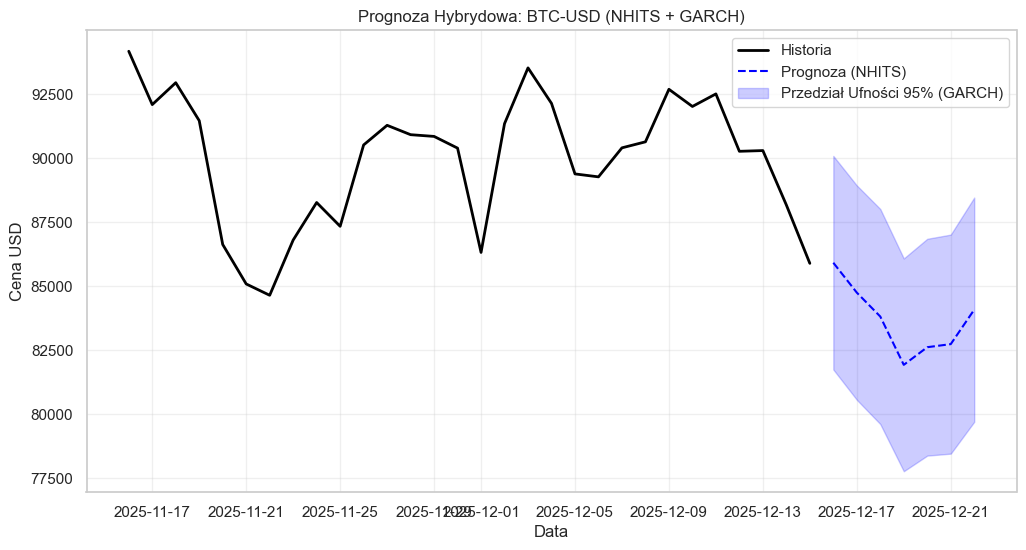

Interpretacja:
Ciemna linia to historia.
Przerywana linia to 'najbardziej prawdopodobna' cena wg AI.
Niebieski cień to obszar, w którym cena powinna się znaleźć z 95% pewnością wg modelu ryzyka.


In [5]:
# Łączymy dane w jeden DataFrame
forecast_df = future_price.copy()
forecast_df['volatility'] = volatility_forecast

# Obliczamy granice kanału (95% Confidence Interval)
# Górna granica = Cena + (1.96 * Zmienność * Cena)
forecast_df['Upper_95'] = forecast_df['NHITS'] * (1 + 1.96 * forecast_df['volatility'])
forecast_df['Lower_95'] = forecast_df['NHITS'] * (1 - 1.96 * forecast_df['volatility'])

# Wizualizacja
plt.figure(figsize=(12, 6))

# 1. Historia (Ostatnie 30 dni)
history = nf_df.tail(30)
plt.plot(history['ds'], history['y'], label='Historia', color='black', linewidth=2)

# 2. Prognoza Ceny (Środek)
plt.plot(forecast_df['ds'], forecast_df['NHITS'], label='Prognoza (NHITS)', color='blue', linestyle='--')

# 3. Wachlarz Ryzyka (GARCH)
plt.fill_between(
    forecast_df['ds'], 
    forecast_df['Lower_95'], 
    forecast_df['Upper_95'], 
    color='blue', alpha=0.2, label='Przedział Ufności 95% (GARCH)'
)

plt.title(f"Prognoza Hybrydowa: {TICKER} (NHITS + GARCH)")
plt.xlabel("Data")
plt.ylabel("Cena USD")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Interpretacja:")
print("Ciemna linia to historia.")
print("Przerywana linia to 'najbardziej prawdopodobna' cena wg AI.")
print("Niebieski cień to obszar, w którym cena powinna się znaleźć z 95% pewnością wg modelu ryzyka.")

## 🧠 Zadanie Domowe: Symulacja Scenariuszy (Monte Carlo)

Zamiast rysować tylko jeden przedział, zróbmy symulację ścieżek.

**Zadanie:**
1. Weź ostatnią znaną cenę Bitcoina.
2. Wygeneruj 100 możliwych ścieżek cenowych na kolejne 7 dni.
3. Wzór na krok symulacji:
   $$ P_{t+1} = P_t \cdot (1 + \text{Trend z NHITS} + \text{Szum z GARCH}) $$
   *   Trend z NHITS: weź procentową zmianę prognozy NHITS.
   *   Szum z GARCH: `np.random.normal(0, volatility_forecast[t])`.
4. Narysuj te 100 linii na wykresie ("Spaghetti Plot").

To pokaże Ci "chmurę prawdopodobieństwa".

🎲 Rozpoczynam symulację Monte Carlo (100 ścieżek)...


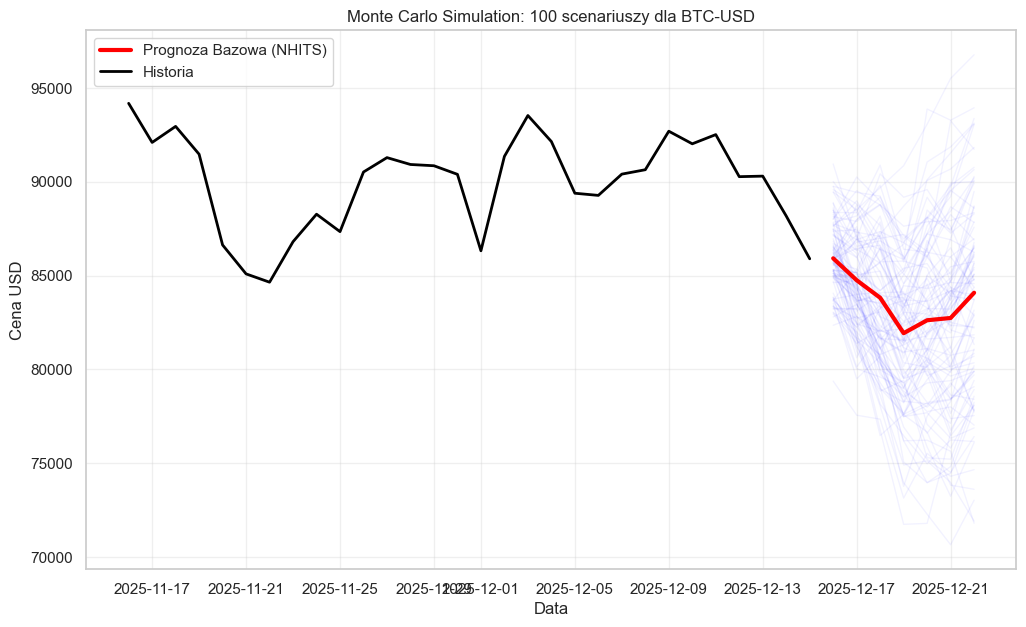

Interpretacja:
- Czerwona linia: Najbardziej prawdopodobna ścieżka wg AI.
- Niebieska chmura: Wszystkie możliwe scenariusze uwzględniające ryzyko (GARCH).


In [6]:
# --- ROZWIĄZANIE ZADANIA DOMOWEGO: Monte Carlo Simulation ---

print("🎲 Rozpoczynam symulację Monte Carlo (100 ścieżek)...")

# 1. Konfiguracja
n_sims = 100
last_price = nf_df['y'].iloc[-1] # Ostatnia znana cena
sim_dates = forecast_df['ds']

# 2. Obliczamy Trend (Procentowa zmiana prognozy NHITS dzień do dnia)
# Musimy dodać ostatnią znaną cenę na początek, żeby policzyć zmianę dla pierwszego dnia prognozy
nhits_prices = [last_price] + future_price['NHITS'].tolist()
trend_pct = pd.Series(nhits_prices).pct_change().dropna().values

# 3. Macierz Symulacji
# Tworzymy tablicę (100 symulacji x 8 punktów czasu - start + 7 dni)
paths = np.zeros((n_sims, HORIZON + 1))
paths[:, 0] = last_price # Punkt startowy dla wszystkich

# 4. Pętla Symulacyjna (Krok po kroku)
for t in range(HORIZON):
    # a. Trend z modelu NHITS dla dnia t
    drift = trend_pct[t]
    
    # b. Zmienność z modelu GARCH dla dnia t
    vol = volatility_forecast[t]
    
    # c. Generujemy losowy szum dla 100 ścieżek
    shocks = np.random.normal(0, vol, n_sims)
    
    # d. Obliczamy cenę dla t+1
    # P_new = P_old * (1 + Trend + Szum)
    paths[:, t+1] = paths[:, t] * (1 + drift + shocks)

# 5. Wizualizacja "Spaghetti Plot"
plt.figure(figsize=(12, 7))

# Rysujemy 100 cienkich linii symulacji
# Transpozycja (.T) żeby plot rysował serie w kolumnach
plt.plot(sim_dates, paths[:, 1:].T, color='blue', alpha=0.05, linewidth=1)

# Rysujemy Główną Prognozę (NHITS)
plt.plot(sim_dates, future_price['NHITS'], color='red', linewidth=3, label='Prognoza Bazowa (NHITS)')

# Rysujemy Historię
plt.plot(history['ds'], history['y'], color='black', linewidth=2, label='Historia')

plt.title(f"Monte Carlo Simulation: {n_sims} scenariuszy dla {TICKER}")
plt.xlabel("Data")
plt.ylabel("Cena USD")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Interpretacja:")
print("- Czerwona linia: Najbardziej prawdopodobna ścieżka wg AI.")
print("- Niebieska chmura: Wszystkie możliwe scenariusze uwzględniające ryzyko (GARCH).")